p:\Kerja\Re-Run-TabularSemanticParsing\.conda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


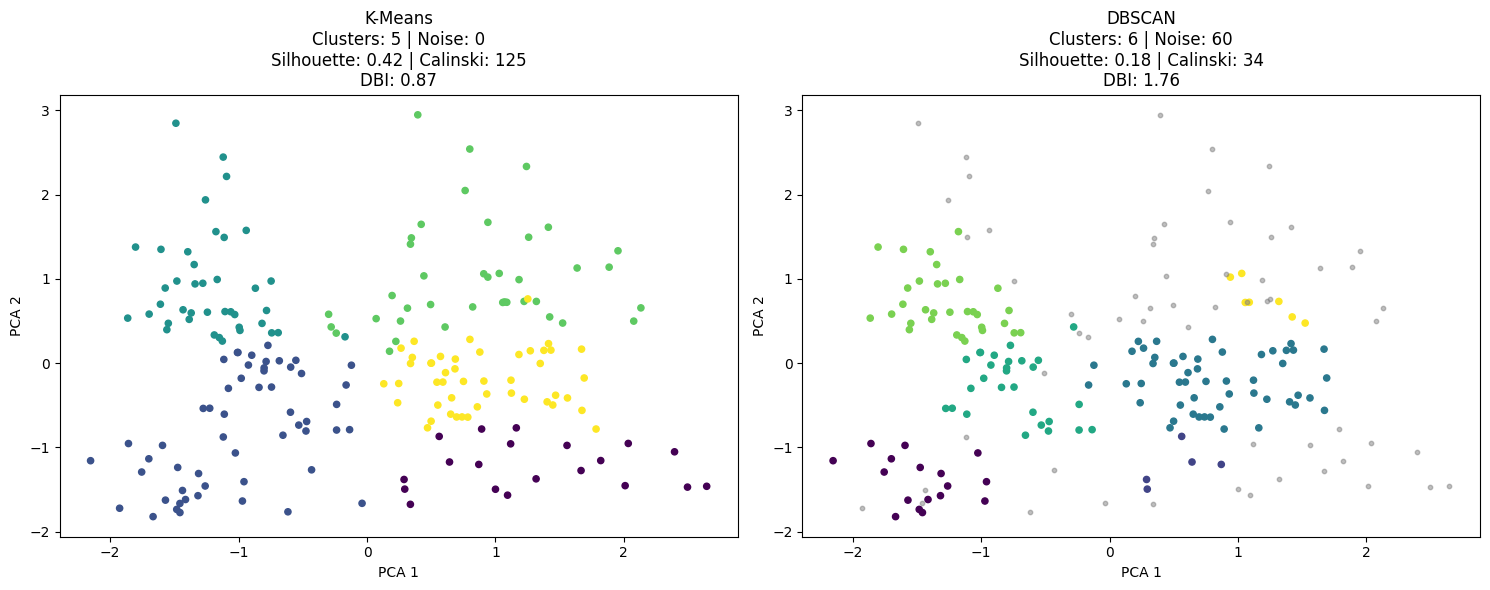


Perbandingan Performa:


,n_clusters,noise_points,silhouette,calinski_harabasz,davies_bouldin
K-Means,5,0,0.42,125,0.87
DBSCAN,6,60,0.18,34,1.76


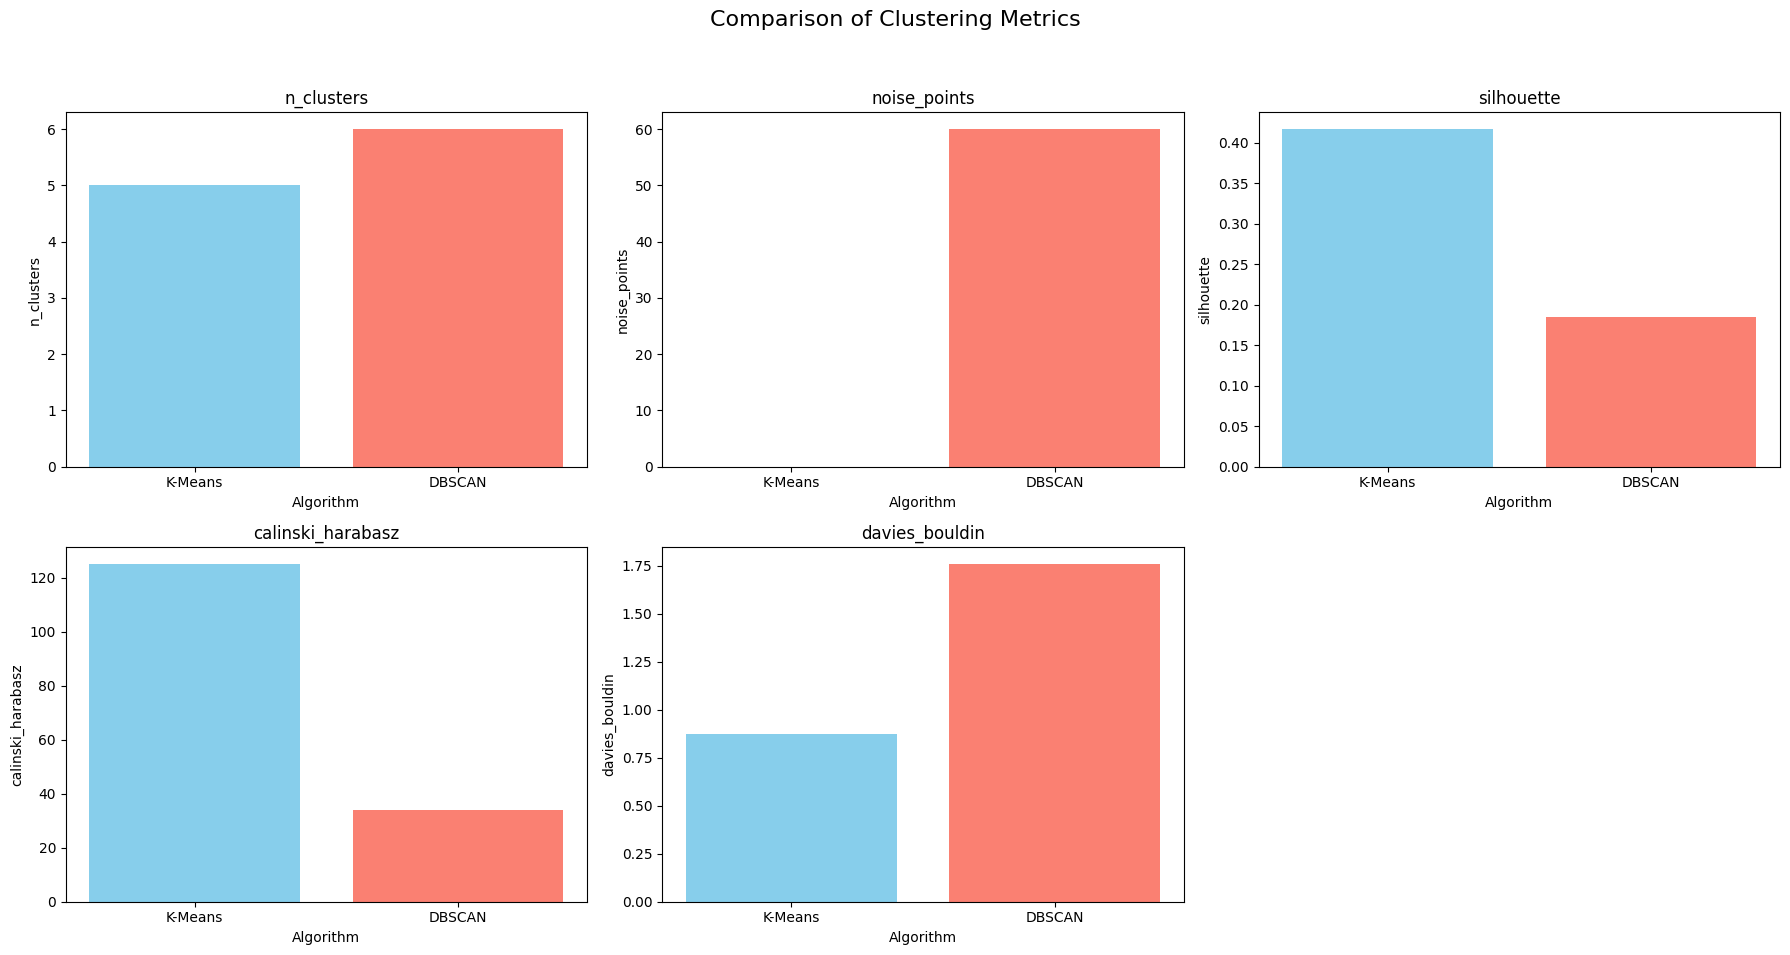

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score, 
    davies_bouldin_score,
    calinski_harabasz_score,
)
from sklearn.decomposition import PCA

# ========================
# LANGKAH 1: LOAD DATA
# ========================
df = pd.read_csv('../datasets/Mall_Customers.csv')

# Pilih kolom numerik
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

# ========================
# LANGKAH 2: PREPROCESSING
# ========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ========================
# LANGKAH 3: CLUSTERING
# ========================
algorithms = {
    'K-Means': KMeans(n_clusters=5, n_init=10, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
}

results = {}

for name, algo in algorithms.items():
    labels = algo.fit_predict(X_scaled)
    
    results[name] = {
        'labels': labels,
        'n_clusters': len(np.unique(labels[labels != -1])) if name == 'DBSCAN' else len(np.unique(labels)),
        'noise_points': np.sum(labels == -1) if name == 'DBSCAN' else 0
    }
    
    try:
        results[name].update({
            'silhouette': silhouette_score(X_scaled, labels),
            'calinski_harabasz': calinski_harabasz_score(X_scaled, labels),
            'davies_bouldin': davies_bouldin_score(X_scaled, labels),
        })
    except Exception as e:
        print(f"Error calculating metrics for {name}: {str(e)}")
        results[name].update({
            'silhouette': -1,
            'calinski_harabasz': -1,
            'davies_bouldin': -1
        })

# ========================
# LANGKAH 4: VISUALISASI CLUSTERING
# ========================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(15, 6))

for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(1, 2, i)
    
    if name == 'DBSCAN':
        core_samples = result['labels'] != -1
        plt.scatter(X_pca[core_samples, 0], X_pca[core_samples, 1], 
                    c=result['labels'][core_samples], cmap='viridis', s=20)
        plt.scatter(X_pca[~core_samples, 0], X_pca[~core_samples, 1], 
                    c='gray', s=10, alpha=0.5, label='Noise')
    else:
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=result['labels'], cmap='viridis', s=20)
    
    title = (
        f"{name}\n"
        f"Clusters: {result['n_clusters']} | Noise: {result['noise_points']}\n"
        f"Silhouette: {result['silhouette']:.2f} | "
        f"Calinski: {result['calinski_harabasz']:.0f}\n"
        f"DBI: {result['davies_bouldin']:.2f}"
    )
    plt.title(title)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()

# ========================
# LANGKAH 5: HASIL METRIK
# ========================
metrics_df = pd.DataFrame(results).T
print("\nPerbandingan Performa:")
display(metrics_df[['n_clusters', 'noise_points', 'silhouette', 'calinski_harabasz', 'davies_bouldin']]
        .style
        .background_gradient(cmap='Blues', subset=['silhouette', 'calinski_harabasz'])
        .background_gradient(cmap='Reds_r', subset=['davies_bouldin'])
        .format({
            'silhouette': "{:.2f}",
            'calinski_harabasz': "{:.0f}",
            'davies_bouldin': "{:.2f}"
        }))

# ========================
# TAMBAHAN: VISUALISASI PERBANDINGAN METRIK
# ========================
# Pilih metrik yang ingin divisualisasikan
metric_names = ['n_clusters', 'noise_points', 'silhouette', 'calinski_harabasz', 'davies_bouldin']

# Membuat grafik bar untuk masing-masing metrik
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, metric in enumerate(metric_names):
    values = metrics_df[metric]
    axs[i].bar(metrics_df.index, values, color=['skyblue', 'salmon'])
    axs[i].set_title(metric)
    axs[i].set_ylabel(metric)
    axs[i].set_xlabel('Algorithm')
    axs[i].set_ylim(bottom=0)

# Hapus subplot kosong kalau ada
fig.delaxes(axs[-1])

plt.suptitle('Comparison of Clustering Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
